In [ ]:
# download data (-q is the quiet mode)
#Can't find a1 file, changed it to a2
! wget -q https://github.com/CISC-372/Notebook/releases/download/a1/test.csv -O test.csv
! wget -q https://github.com/CISC-372/Notebook/releases/download/a1/train.csv -O train.csv



traning 7631
testing 7632


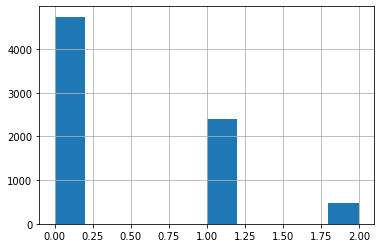

In [ ]:
import pandas as pd

#setting up training data
Xy_train = pd.read_csv('train.csv', engine='python')
#seperate tranning 
X_train = Xy_train.drop(columns=['price_rating'])
y_train = Xy_train[['price_rating']]

print('traning', len(X_train))
Xy_train.price_rating.hist()

#setting up testing set
X_test = pd.read_csv('test.csv', engine='python')
testing_ids = X_test.Id
print('testing', len(X_test))

In [ ]:
# model training and tuning
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#make model more accurate by adding more features
#the numeric features that needs
numeric_features = [ 'bedrooms', 'accommodates', 'beds','bathrooms','guests_included','availability_365','number_of_reviews',
                    'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 
                    'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','minimum_nights','maximum_nights',
                    'minimum_nights_avg_ntm', 'maximum_minimum_nights',
                    'minimum_minimum_nights','availability_30','availability_60','availability_90'
                  ]

# fixing missing imput with the mean of each column and standerize the data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#the categorical features that needs
categorical_features = [
                        'property_type', 'is_business_travel_ready', 'room_type','host_is_superhost','bed_type','cancellation_policy']
# fix the missing value wirh fill_value OneHotEncoder Encode categorical features as a one-hot numeric array.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#transform the list in the transformers (list of num and cat) to the subset of the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# apply pipeline opration
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestClassifier ())])

#getting the data from the numeric and categorical cells
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]


# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)
#incase of 
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth':[10, 20]
}

#using grid search
random_search_1 = GridSearchCV(
    model, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='accuracy')
random_search_1.fit(X_train, y_train)

print('best score {}'.format(random_search_1.best_score_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


best score 0.7193031333764197


In [ ]:
# Prediction & generating the submission file
y_pred = random_search_1.predict(X_test)
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('submission.csv', index=False)